In [3]:
# --- 1. CORE LIBRARIES AND UTILITIES ---
# Standard data manipulation and visualization libraries
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

# --- 2. SCIKIT-LEARN: MODEL SELECTION & METRICS ---
# Tools for splitting data, cross-validation, and performance evaluation
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_val_score, 
    GridSearchCV
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    roc_auc_score
)
from sklearn.pipeline import Pipeline # For creating robust modeling workflows
from sklearn.impute import SimpleImputer # Tool to handle NaNs
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import lightgbm as lgb

import os
import sys
import joblib

# Define project Path in Colab
PROJECT_BASE_PATH = '/content/drive/MyDrive/Project_01' 

# ADD 'src' DIRECTORY TO PYTHON PATH
SRC_PATH = os.path.join(PROJECT_BASE_PATH, 'src')

# verify if SRC_PATH is already in sys.path
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
    print("✅ Successfully added 'src' directory to Python path.")

# IMPORT Paths CLASS FROM config MODULE
from config import Paths

try:
    from config import Paths
    
    # 3. Initialize instance of Paths class to manage project directories and files
    cfg = Paths(PROJECT_BASE_PATH) # <-- Change here if needed
    cfg.create_dirs() 
    
    print("\n✅ Project configuration (Paths) initialized successfully.")
    print(f"Raw Data Path check: {cfg.TRAIN_RAW_FILE}")
    
except ImportError:
    print("❌ Error: Could not import Paths from config module.")

FINAL_TRAIN_FILE = os.path.join(cfg.DATA_PROCESSED_DIR, 'train_final_encoded.parquet')
FINAL_TEST_FILE = os.path.join(cfg.DATA_PROCESSED_DIR, 'test_final_encoded.parquet')

try:
    # Read the Parquet files
    df_train_final = pd.read_parquet(FINAL_TRAIN_FILE)
    df_test_final = pd.read_parquet(FINAL_TEST_FILE)
    
    print(f"✅ Loaded Encoded Train Data. Shape: {df_train_final.shape}")
    print(f"✅ Loaded Encoded Test Data. Shape: {df_test_final.shape}")

except FileNotFoundError:
    print("❌ ERROR: Parquet files not found. Ensure that the parquet was executed successfully in Feature_Eng notebook and saved the files.")
    # Exit or raise an error if critical data is missing
    raise


✅ Project configuration (Paths) initialized successfully.
Raw Data Path check: /content/drive/MyDrive/Project_01/data/raw/application_train.csv
✅ Loaded Encoded Train Data. Shape: (307511, 135)
✅ Loaded Encoded Test Data. Shape: (48744, 134)


--- Starting: Final Model Training Pipeline ---


Initial Dataset Shape (before Feature Selection): (307511, 133)
--- Calculating Feature Importance for Elbow Method Analysis... ---

✅ Statistical Analysis (Elbow Method):
  - Elbow point found at 25 features (farthest distance from optimal line).
  - This count covers 88.73% of the total model importance.
  - Selecting the Top 25 Features for the final model.


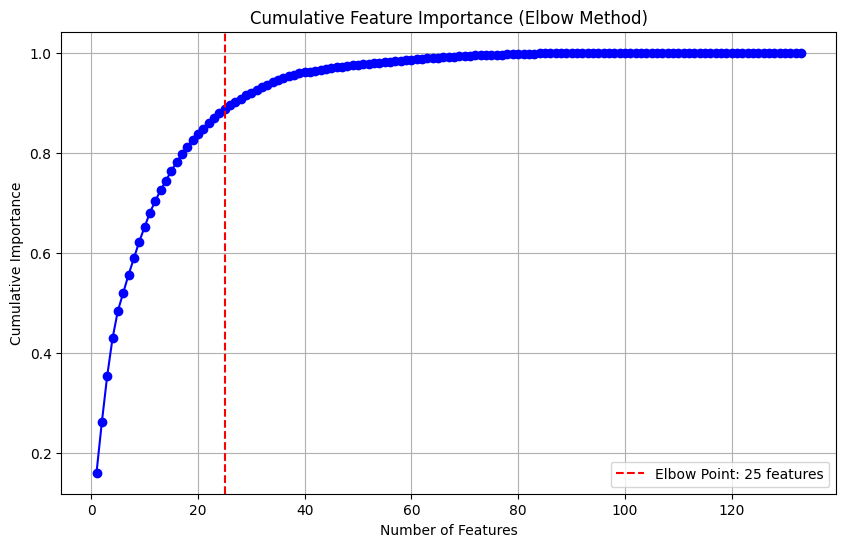


✅ Feature matrices after Selection. New Training Shape: (307511, 25)

--- Training final model with 25 Optimized Features ---
✅ Final training completed in 39.47 seconds.
✅ MLOps Artifact: Optimized Model (25 features) saved to: /content/drive/MyDrive/Project_01/models/final_lgbm_optimized_model.pkl
✅ MLOps Artifact: Imputation Means Map saved to: /content/drive/MyDrive/Project_01/models/imputation_means_map.pkl

✅ MLOps Artifact: Final Submission file saved successfully!


In [ ]:
# Final LightGBM Training with Optimized Hyperparameters and Feature Selection via Elbow Method

# --- Exclusions ---
EXCLUDED_COLS = ['SK_ID_CURR', 'TARGET'] 
IMPUTATION_FILL_VALUE = 0 # Imputation value for quick feature importance calculation

print("--- Starting: Final Model Training Pipeline ---")

# 1. Prepare Features (X) and Target (y) - Use all 133 initial features
X = df_train_final.drop(columns=EXCLUDED_COLS, errors='ignore')
y = df_train_final['TARGET']
X_test = df_test_final.drop(columns='SK_ID_CURR', errors='ignore')

print(f"Initial Dataset Shape (before Feature Selection): {X.shape}") 


# --- CRITICAL STEP: FEATURE SELECTION VIA ELBOW METHOD ON IMPORTANCE ---

# 2a. Train a quick, simple model to calculate feature importance
temp_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42, verbose=-1)

print("--- Calculating Feature Importance for Elbow Method Analysis... ---")

# Use simple imputation (0) for quick calculation (only for feature selection step)
temp_model.fit(X.fillna(IMPUTATION_FILL_VALUE), y) 

# 2b. Extract, Normalize, and Calculate Cumulative Importance
feature_importances = pd.Series(temp_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances_normalized = feature_importances / feature_importances.sum()
feature_importance_cumulative = feature_importances_normalized.cumsum()


# 2c. Plot and determine the Elbow Point (The most efficient point for feature reduction)
# We will use a visual cue and an automated heuristic for justification.

def find_elbow_point_distance(cumulative_importance: pd.Series):
    """
    Finds the elbow point using the distance method: 
    the point farthest from the line connecting (0,0) and (max_features, 1.0).
    """
    points = cumulative_importance.reset_index(drop=True)
    n_points = len(points)
    
    # Coordinates of the line end points
    p1 = [0, 0] 
    p2 = [n_points, 1.0] 
    
    distances = []
    for i in range(n_points):
        p3 = [i + 1, points.iloc[i]] 
        # Calculate distance from point p3 to the line p1-p2
        distance = np.abs((p2[1] - p1[1]) * p3[0] - (p2[0] - p1[0]) * p3[1] + p2[0] * p1[1] - p2[1] * p1[0]) / np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
        distances.append(distance)
        
    # The elbow point is the index with the maximum distance
    elbow_index = np.argmax(distances)
    return elbow_index + 1 # Convert index to feature count

N_FEATURES_ELBOW = find_elbow_point_distance(feature_importance_cumulative) 
selected_features = feature_importances.nlargest(N_FEATURES_ELBOW).index.tolist()

print(f"\n✅ Statistical Analysis (Elbow Method):")
print(f"  - Elbow point found at {N_FEATURES_ELBOW} features (farthest distance from optimal line).")
print(f"  - This count covers {feature_importance_cumulative.iloc[N_FEATURES_ELBOW-1]*100:.2f}% of the total model importance.")
print(f"  - Selecting the Top {N_FEATURES_ELBOW} Features for the final model.")


# Visualization to justify the choice
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(feature_importance_cumulative) + 1), feature_importance_cumulative, marker='o', linestyle='-', color='b')
plt.axvline(x=N_FEATURES_ELBOW, color='r', linestyle='--', label=f'Elbow Point: {N_FEATURES_ELBOW} features')
plt.title('Cumulative Feature Importance (Elbow Method)')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.legend()
plt.grid(True)
plt.show() # Renders the justification plot in the notebook

# Store the final list
FINAL_MODEL_FEATURES = selected_features 

# 3. Apply Feature Selection (Dimensionality Reduction)
X = X[FINAL_MODEL_FEATURES]
X_test = X_test[FINAL_MODEL_FEATURES]

N_FEATURES_FINAL = len(FINAL_MODEL_FEATURES)
print(f"\n✅ Feature matrices after Selection. New Training Shape: {X.shape}") 


# 4. Final NaN/Inf Handling (Crucial for MLOps Artifacts)
# 1. Calculate imputation means only from the *selected* training set (X)
imputation_means = X.replace([np.inf, -np.inf], np.nan).mean().to_dict()
imputation_means['DAYS_EMPLOYED_ANOMALY'] = 365243 

# 2. Apply imputation to X (Training Data)
X = X.replace([np.inf, -np.inf], np.nan).fillna(pd.Series(imputation_means))

# 3. Apply imputation to X_test (Test Data)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(pd.Series(imputation_means))


# 5. Configure and Train the Final Optimized Model
# Using optimal parameters from the 05_Grid_Search_LightGBM notebook
OPTIMAL_PARAMS = {
    'n_estimators': 1000,   
    'learning_rate': 0.01, 
    'num_leaves': 63,
    'objective': 'binary',    
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': 42,
    'verbose': -1,
}

final_model = lgb.LGBMClassifier(**OPTIMAL_PARAMS)

print(f"\n--- Training final model with {N_FEATURES_FINAL} Optimized Features ---")

start_time = time()
# Train the model with the justified 'N' features
final_model.fit(X, y) 
end_time = time()

print(f"✅ Final training completed in {(end_time - start_time):.2f} seconds.")


# 6. MLOps Artifacts Saving

# 6a. MLOps Artifact 1: Save the Optimized Model 
model_file_path = os.path.join (cfg.MODEL_DIR, 'final_lgbm_optimized_model.pkl')
joblib.dump(final_model, model_file_path)
print(f"✅ MLOps Artifact: Optimized Model ({N_FEATURES_FINAL} features) saved to: {model_file_path}")

# 6b. MLOps Artifact 2: Save the Imputation Means Map (CRUCIAL for API)
means_map_path = os.path.join (cfg.MODEL_DIR, 'imputation_means_map.pkl')
joblib.dump(imputation_means, means_map_path)
print(f"✅ MLOps Artifact: Imputation Means Map saved to: {means_map_path}")

# 6c. MLOps Artifact 3: Submission File Creation
submission_ids = df_test_final['SK_ID_CURR'].astype(int)

df_submission = pd.DataFrame({
    'SK_ID_CURR': submission_ids,
    'TARGET': final_model.predict_proba(X_test)[:, 1]
})

submission_file_path = os.path.join(cfg.SUBMISSION_DIR,  'submission_lgbm_final.csv')

df_submission.to_csv(submission_file_path, index=False)

print("\n=======================================================")
print(f"✅ MLOps Artifact: Final Submission file saved successfully!")
print("=======================================================")